In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [2]:
#test CPU type
import tensorflow as tf
#tf.test.gpu_device_name()

# Data

In [3]:
data = pd.read_csv('/Users/stavros/Documents/Data Science/Final Project/crimes_clean.csv')

In [4]:
data.head()

,Unnamed: 0,ID,Date,Block,Primary Type,Description,Arrest,Domestic,Beat,District,Community Area,Year,Latitude,Longitude,Month,Week,Day,Time,Hour
0,0,10224738,2015-09-05 13:30:00,043XX S WOOD ST,BATTERY,DOMESTIC BATTERY SIMPLE,False,True,924,9.0,61.0,2015,41.815117,-87.670000,9,2015-08-29 13:30:00,5,13:30:00,13
1,1,10224739,2015-09-04 11:30:00,008XX N CENTRAL AVE,THEFT,POCKET-PICKING,False,False,1511,15.0,25.0,2015,41.895080,-87.765400,9,2015-08-28 11:30:00,4,11:30:00,11
2,3,10224740,2015-09-05 12:45:00,035XX W BARRY AVE,NARCOTICS,POSS: HEROIN(BRN/TAN),True,False,1412,14.0,21.0,2015,41.937406,-87.716650,9,2015-08-29 12:45:00,5,12:45:00,12
3,4,10224741,2015-09-05 13:00:00,0000X N LARAMIE AVE,ASSAULT,SIMPLE,False,True,1522,15.0,25.0,2015,41.881903,-87.755121,9,2015-08-29 13:00:00,5,13:00:00,13
4,5,10224742,2015-09-05 10:55:00,082XX S LOOMIS BLVD,BURGLARY,FORCIBLE ENTRY,False,False,614,6.0,71.0,2015,41.744379,-87.658431,9,2015-08-29 10:55:00,5,10:55:00,10


# Preprocessing - specific to KNN model

In [5]:
data = data.replace(to_replace='None', value=np.nan).dropna()

**Label Encoding categorical variables**

In [6]:
# create an instance of label encoder for categorical variables
labelEncoder = LabelEncoder()

In [7]:
primaryEncoded = labelEncoder.fit_transform(data['Primary Type'])
primaryEncoded

array([ 2, 33, 18, ...,  2,  2, 34])

In [8]:
data['Primary Type'] = primaryEncoded

In [9]:
# create an instance of label encoder for categorical variables
labelEncoder2 = LabelEncoder()

In [10]:
blockEncoded = labelEncoder2.fit_transform(data['Block'])
blockEncoded

array([21958,  5058, 18924, ..., 25798,  1498, 15908])

In [11]:
data['Block'] = blockEncoded

In [12]:
data = data.drop('Date', axis=1)

In [13]:
labelEncoder3 = LabelEncoder()

In [14]:
descEncoded = labelEncoder3.fit_transform(data['Description'])
descEncoded

array([209, 363, 379, ..., 209, 410, 416])

In [15]:
data['Description'] = descEncoded

In [16]:
data = data.drop('Time', axis=1)
data = data.drop('Week', axis=1)

Use PCA to combine features

In [17]:
from sklearn.decomposition import PCA

In [18]:
location = data[['Latitude','Longitude']]
pca = PCA(n_components=1,random_state=123)

In [19]:
loc = pca.fit_transform(location)

In [20]:
data['Location'] = loc

In [21]:
data.head(5)

,Unnamed: 0,ID,Block,Primary Type,Description,Arrest,Domestic,Beat,District,Community Area,Year,Latitude,Longitude,Month,Day,Hour,Location
0,0,10224738,21958,2,209,False,True,924,9.0,61.0,2015,41.815117,-87.670000,9,5,13,0.024910
1,1,10224739,5058,33,363,False,False,1511,15.0,25.0,2015,41.895080,-87.765400,9,4,11,-0.087944
2,3,10224740,18924,18,379,True,False,1412,14.0,21.0,2015,41.937406,-87.716650,9,5,12,-0.105624
3,4,10224741,265,1,445,False,True,1522,15.0,25.0,2015,41.881903,-87.755121,9,5,13,-0.071653
4,5,10224742,33258,3,235,False,False,614,6.0,71.0,2015,41.744379,-87.658431,9,5,10,0.093886


# Feature selection

Checking importance of features using an ExtraTreesClassifier

In [22]:
#taking a fraction of data
data_sample = data.sample(frac=0.1, random_state=123)

In [23]:

from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()

In [24]:

X = data_sample.loc[:, data.columns != 'Primary Type']

model.fit(X,data_sample['Primary Type'])

ExtraTreesClassifier()

In [25]:
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers

[0.03196042 0.03466678 0.03271356 0.52426511 0.05181323 0.04665244
 0.02723343 0.01111794 0.01908709 0.02398396 0.03412773 0.03542563
 0.02794417 0.03046408 0.03483437 0.03371004]


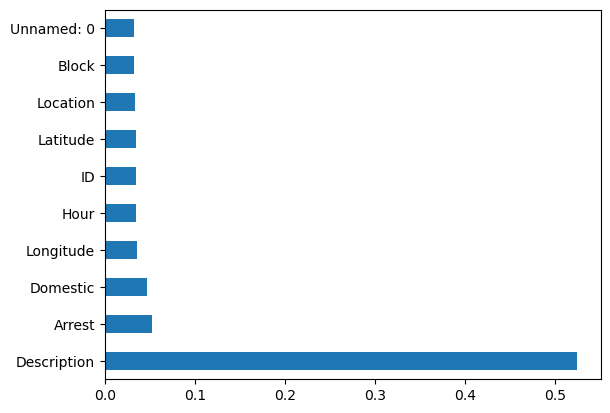

In [26]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
#plot for top 10 features
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

Find corelation between data to find dependency between data columns

In [27]:
corelation = data.corr()
corelation

,Unnamed: 0,ID,Block,Primary Type,Description,Arrest,Domestic,Beat,District,Community Area,Year,Latitude,Longitude,Month,Day,Hour,Location
Unnamed: 0,1.000000,0.273482,0.003378,0.003886,-0.003727,-0.015890,0.014764,-0.002205,0.003253,0.006527,0.259796,-0.008093,-0.000418,0.003141,-0.001742,-0.012214,0.006731
ID,0.273482,1.000000,-0.023652,0.011202,-0.044156,-0.096534,0.067073,-0.036659,-0.004598,-0.012652,0.983736,0.003798,0.009466,0.001220,0.000477,-0.015719,-0.000630
Block,0.003378,-0.023652,1.000000,-0.079148,-0.004329,-0.034633,0.073080,-0.121495,-0.111619,0.386256,-0.024361,-0.348435,0.086915,-0.002608,-0.001853,0.001922,0.318421
Primary Type,0.003886,0.011202,-0.079148,1.000000,-0.223295,0.021927,-0.250192,0.041616,0.037707,-0.075597,0.007172,0.079070,-0.003436,0.007708,-0.004505,0.027828,-0.067814
Description,-0.003727,-0.044156,-0.004329,-0.223295,1.000000,0.169162,-0.098319,-0.001599,-0.001691,0.003061,-0.046227,-0.003376,-0.002143,-0.012435,0.002348,0.042242,0.002270
Arrest,-0.015890,-0.096534,-0.034633,0.021927,0.169162,1.000000,-0.066526,-0.016429,-0.017489,-0.001657,-0.100857,-0.002535,-0.034161,-0.020252,-0.001170,0.081298,-0.007178
Domestic,0.014764,0.067073,0.073080,-0.250192,-0.098319,-0.066526,1.000000,-0.047258,-0.043865,0.077903,0.069672,-0.083648,0.008005,-0.011433,-0.000968,-0.032770,0.072933
Beat,-0.002205,-0.036659,-0.121495,0.041616,-0.001599,-0.016429,-0.047258,1.000000,0.950561,-0.500319,-0.038305,0.620282,-0.490010,0.004152,-0.001090,-0.007245,-0.658339
District,0.003253,-0.004598,-0.111619,0.037707,-0.001691,-0.017489,-0.043865,0.950561,1.000000,-0.494716,-0.005939,0.627418,-0.535627,0.003784,-0.001093,-0.007418,-0.676822
Community Area,0.006527,-0.012652,0.386256,-0.075597,0.003061,-0.001657,0.077903,-0.500319,-0.494716,1.000000,-0.012991,-0.753341,0.241088,-0.005309,-0.000386,0.002517,0.702956


<AxesSubplot:>

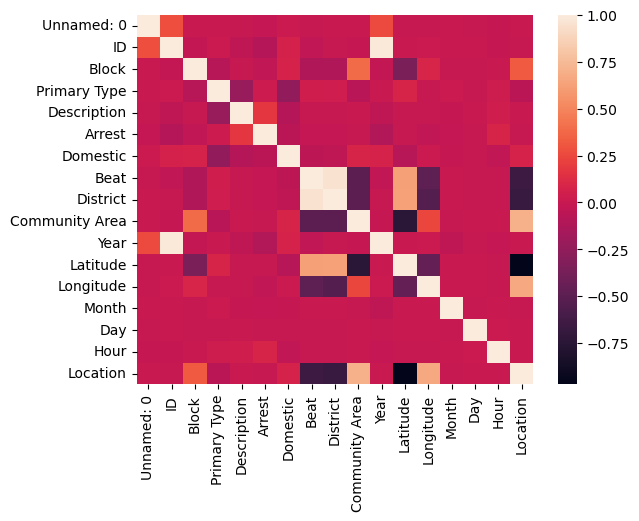

In [28]:
sns.heatmap(corelation)

**selected columns for KNN model**

In [29]:
selected_columns = ['Latitude','Longitude','Arrest','Block','Community Area']


# Splitting data in train and test

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data[selected_columns], data['Primary Type'], test_size=0.3) # 70% training and 30% test

# Building initial KNN Classifier

**Initially build classifier with 5 neighbours**

In [31]:
knn_5 = KNeighborsClassifier(n_neighbors=5) 
knn_5.fit(X_train,y_train)
pred_train = knn_5.predict(X_train)
pred_i = knn_5.predict(X_test)
print('Test accuracy ', metrics.accuracy_score(y_train, pred_train))
print('Accuracy ', metrics.accuracy_score(y_test, pred_i))
print('F1 score ', metrics.f1_score(y_test, pred_i, average = 'weighted'))

Test accuracy  0.39488329828429986
Accuracy  0.29640695109567355
F1 score  0.2807419939492898


Deploy Elbow method to get optimum number of neighbours

In [32]:
error_rate = []

krange = range(10,50,5)
for i in krange:
 
 knn = KNeighborsClassifier(n_neighbors=i, metric='manhattan', weights = 'uniform',n_jobs= -1) # haversine - if only lat long
 knn.fit(X_train,y_train)
 pred_train = knn.predict(X_train)
 pred_i = knn.predict(X_test)
 error_rate.append(np.mean(pred_i != y_test))
 print('Neighbours ',i)
 print('Test accuracy ', metrics.accuracy_score(y_train, pred_train))
 print('Accuracy ', metrics.accuracy_score(y_test, pred_i))
 print('F1 score ', metrics.f1_score(y_test, pred_i, average = 'weighted'))

Neighbours  10
Test accuracy  0.3979053690424746
Accuracy  0.3229626700063718
F1 score  0.2921797113456945
Neighbours  15
Test accuracy  0.3923830224433226
Accuracy  0.33212393210157826
F1 score  0.2929890146477545
Neighbours  20
Test accuracy  0.3862451257005798
Accuracy  0.3362345588790207
F1 score  0.29158230828913034
Neighbours  25
Test accuracy  0.3816122255177571
Accuracy  0.3393798618454928
F1 score  0.2899096914153015
Neighbours  30
Test accuracy  0.37733756037027993
Accuracy  0.34069768885908375
F1 score  0.2875342570151468
Neighbours  35
Test accuracy  0.37344098671439313
Accuracy  0.3412068601517579
F1 score  0.28518252309003034
Neighbours  40
Test accuracy  0.37030141486462503
Accuracy  0.3413057330012734
F1 score  0.28305907731693514
Neighbours  45
Test accuracy  0.36746890161658163
Accuracy  0.34134633296363487
F1 score  0.2813015701944791


Text(0, 0.5, 'Error Rate')

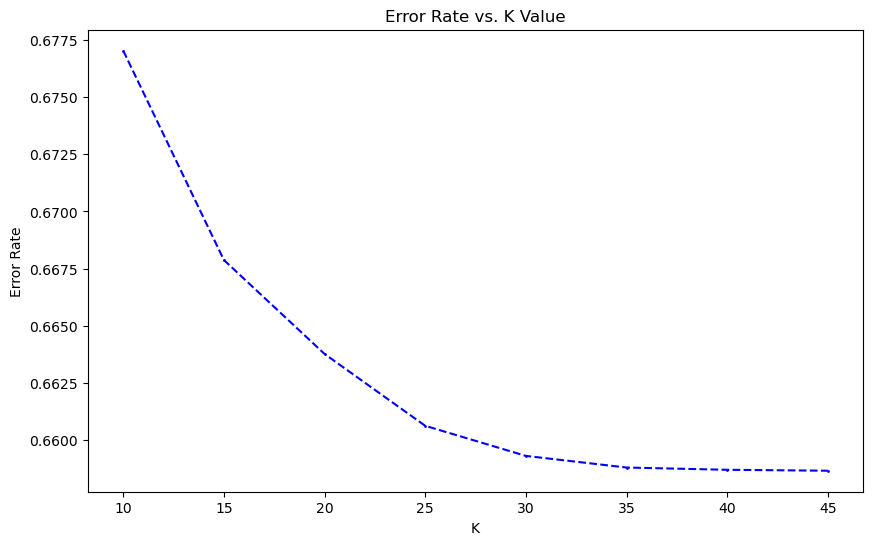

In [33]:
plt.figure(figsize=(10,6))

plt.plot(krange,error_rate, color= 'blue', linestyle= 'dashed', marker= 'o', markerfacecolor='red', markersize=1)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

K = 25, optimum

# Grid Search/ Random Search -KNN (DID NOT COMPLETE AFTER 20HRS)

**To find optimal paramteres for KNN Model by implementing Grid search.**

In [56]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [57]:
KNeighborsClassifier().get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [58]:
grid_params = {
    'weights' : ['uniform', 'distance'],
    'metric' : ['manhattan','jaccard'] #haversine - if only lat long
}

In [59]:
randomSearch = RandomizedSearchCV(
    KNeighborsClassifier(25),
    grid_params,
    verbose = 1,
    cv =3,
    random_state = 123
    )


In [ ]:
#takes very long time
rs_results = randomSearch.fit(X_train, y_train)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 4 candidates, totalling 12 fits


In [ ]:
rs_results.best_score_

In [ ]:
rs_results.best_params_

# Oversmapling -SMOTE to balance dataset

In [42]:
from imblearn.over_sampling import SMOTE

In [43]:
# Oversample 'Majority'
sm = SMOTE('minority', random_state=123)

/opt/anaconda3/lib/python3.9/site-packages/imblearn/utils/_validation.py:586: FutureWarning: Pass sampling_strategy=minority as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(


In [44]:
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

AttributeError: 'NoneType' object has no attribute 'split'

In [ ]:
#convert back to Dataframe
X_train_updated = pd.DataFrame(X_train_res, columns= selected_columns)
y_train_updated = pd.Series(y_train_res)

In [ ]:
target_counts = y_train_updated.value_counts()
target_counts

In [ ]:
knn = KNeighborsClassifier(n_neighbors=25, metric='manhattan', weights = 'uniform')

In [ ]:
knn.fit(X_train_updated,y_train_updated)

In [ ]:
pred_i = knn.predict(X_test)

In [ ]:
print('Accuracy ', metrics.accuracy_score(y_test, pred_i))
print('F1 score ', metrics.f1_score(y_test, pred_i, average = 'weighted'))

# Undersampling - Cluster Centroids

In [45]:
from imblearn.under_sampling import ClusterCentroids

In [46]:
# Undersample 'Majority'
cc = ClusterCentroids(sampling_strategy = 'majority')

In [48]:
X_cc, y_cc = cc.fit_resample(X_train, y_train)

AttributeError: 'NoneType' object has no attribute 'split'

In [ ]:
#convert back to Dataframe
X_train_updated = pd.DataFrame(X_cc, columns= selected_columns)
y_train_updated = pd.Series(y_cc)

In [ ]:
target_counts = y_train_updated.value_counts()
target_counts

In [ ]:
knn = KNeighborsClassifier(n_neighbors=25, metric='manhattan', weights = 'uniform')

In [ ]:
knn.fit(X_train_updated,y_train_updated)

In [ ]:
pred_i = knn.predict(X_test)

In [ ]:
print('Accuracy ', metrics.accuracy_score(y_test, pred_i))
print('F1 score ', metrics.f1_score(y_test, pred_i, average = 'weighted'))

# Random Sampling

In [49]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [50]:
# define oversampling strategy
over = RandomOverSampler(sampling_strategy= 'minority') 

In [51]:
# fit and apply the transform
X_random, y_random = over.fit_resample(X_train, y_train)

In [52]:
#convert back to Dataframe
X_train_updated = pd.DataFrame(X_random, columns= selected_columns)
y_train_updated = pd.Series(y_random)

In [53]:
target_counts_random = y_train_updated.value_counts()
target_counts_random

33    1033482
21    1033482
2      896788
6      559585
18     467139
1      319291
25     303218
3      271092
17     227680
9      210690
30     184361
8      135996
34      67497
26      42768
23      34159
28      33939
31      18188
5       16845
13      12349
10       9374
16       8921
11       8261
0        8142
15       4191
7        3633
32       2928
14       2888
4         703
22        511
27        129
20        117
24         92
12         62
19         26
29          9
Name: Primary Type, dtype: int64

In [54]:
knn = KNeighborsClassifier(n_neighbors=25, metric='manhattan', weights = 'uniform')

In [55]:
knn.fit(X_train_updated,y_train_updated)

KNeighborsClassifier(metric='manhattan', n_neighbors=25)

In [56]:
pred_i = knn.predict(X_test)

In [57]:
print('Accuracy ', metrics.accuracy_score(y_test, pred_i))
print('F1 score ', metrics.f1_score(y_test, pred_i, average = 'weighted'))

Accuracy  0.3393512030485318
F1 score  0.2895700845969981


OverSampling minority class improves model 

In [58]:
# define undersampling strategy
under = RandomUnderSampler(sampling_strategy= 'majority')

In [59]:
# fit and apply the transform
X_train_updated, y_train_updated = under.fit_resample(X_train, y_train)

In [60]:
y_train_updated = pd.Series(y_train_updated)
target_counts_random = y_train.value_counts()
target_counts_random

33    1033482
2      896788
6      559585
18     467139
1      319291
25     303218
3      271092
17     227680
9      210690
30     184361
8      135996
34      67497
26      42768
23      34159
28      33939
31      18188
5       16845
13      12349
10       9374
16       8921
11       8261
0        8142
15       4191
7        3633
32       2928
14       2888
4         703
22        511
27        129
20        117
24         92
12         62
19         26
29          9
21          7
Name: Primary Type, dtype: int64

In [61]:
knn = KNeighborsClassifier(n_neighbors=25, metric='manhattan', weights = 'uniform')

In [62]:
knn.fit(X_train_updated,y_train_updated)

KNeighborsClassifier(metric='manhattan', n_neighbors=25)

In [63]:
pred_i = knn.predict(X_test)

In [64]:
print('Accuracy ', metrics.accuracy_score(y_test, pred_i))
print('F1 score ', metrics.f1_score(y_test, pred_i, average = 'weighted'))

Accuracy  0.2415755078099998
F1 score  0.1861703841144305


Oversampling does not have significant impact on model

# Ensemble models

Ensemble of various classification models 

In [66]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [67]:
#KNN with - 25 neighbours
knn = KNeighborsClassifier(25, metric='manhattan', weights = 'uniform',n_jobs= -1)

#random forest with 75 Decision Trees
rf = RandomForestClassifier(10, max_depth = 10, n_jobs= -1)

#Support Vector Classifier
svm = SVC(kernel = 'linear', random_state = 123, probability=True)

In [69]:
# can using previopusly trained KNN as well
knn.fit(X_train,y_train)

KNeighborsClassifier(metric='manhattan', n_jobs=-1, n_neighbors=25)

In [70]:
rf.fit(X_train,y_train)

RandomForestClassifier(max_depth=10, n_estimators=10, n_jobs=-1)

In [71]:
rf.score(X_test, y_test)

0.3253700089510976

In [ ]:
svm.fit(X_train,y_train)

In [ ]:
svm.score(X_test, y_test)

In [ ]:
#create a dictionary of our models
estimators=[('knn', knn), ('rf', rf), ('svm', svm)]
#create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting='hard')

In [ ]:
#fit model to training data
ensemble.fit(X_train, y_train)
#test our model on the test data
ensemble.score(X_test, y_test)